## Load-DQN
After training a DQN and a DSQN in the first experiment (DQN-Training) we now load the saved models and test their performance. Additionally we create a replay dataset using the DQN which we use in the next experiment to train a classifier that learns the policy of the DQN. 
Additionally, this file can be seen as a tutorial for loading any network, as we will use the same method to load converted networks as well.
Experiments:
1. DQN-Training (How to train a conventional DQN and a spiking DQN using Surrogate Gradients (DSQN).)
2. Load-DQN (How to load a previously saved D(S)QN and how to save a replay dataset.)
3. Train-Classifier (How to train a spiking or non-spiking classifier on the saved replay data set.)
4. SNN-Conversion (How to convert a DQN and a Classifier to a SNN.)
5. Load in NEST (How to load a converted or directly trained spiking network in NEST.)
6. Conversion in pyNN with NEST or SpyNNaker (How to load spiking network in pyNN using NEST or SpyNNaker as backend.)

In [1]:
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
# hack to perform relative imports
sys.path.append('../../')
from Code import load_agent, SQN, FullyConnected

Detected PyNN version 0.9.5 and Neo version 0.6.1


First, we choose the model that we want to learn (by giving the path to the correct folder) and for reproducibility we again fix the random seeds.

In [2]:
# we first load the trained DQN
os.chdir('./../../Results/CartPole-A/DQN/trained')

# set seeds
torch.manual_seed(1)
random.seed(1)
gym_seed = 1

# set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Now we create the environment, load the network and set some hyperparameters.

In [3]:
env = 'CartPole-v0'

# load the network, take care that you choose the same architecture and class as the model that is loaded
architecture = [4, 16, 16, 2]
policy_net = FullyConnected(architecture).to(device)
policy_net.load_state_dict(torch.load('model.pt'))

# hyperparameters
MAX_STEPS = 500 # when loading we let the agent run for a bit longer to get a better idea on how it behaves
# we use a greedy policy for loading the agent (no random actions).
# In hindsight it might be better to use an epsilon greedy policy when creating the replay memory as it lets the agents
# see more different states which could lead to better learning of the classifier.
EPSILON = 0 

We now load the agent and report its performance. The replay memory is saved in the current directory in the files memory_input.npz (for the input states) and memory_output.npz (for the actions the agent predicted for the corresponding states). Everything else from the replay memory, like rewards and next states, is discarded.

<div class="alert alert-block alert-warning">
<b>Attention:</b> If the files memory_input.npz and memory_ouput.npz already exist in the directory, they are overwritten without any warnings.
</div>

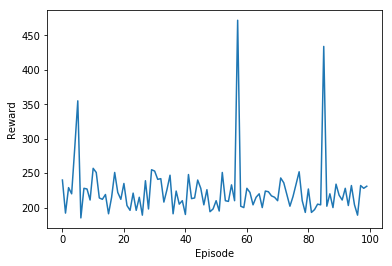

Complete
Mean:  224.33
Std:  40.370520047293034


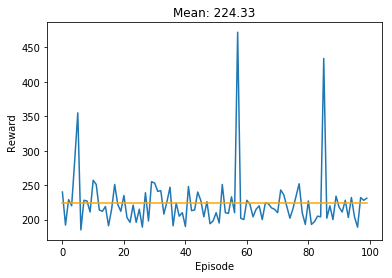

In [4]:
load_agent(env,policy_net,device,save_replay=True,max_steps=MAX_STEPS,epsilon=EPSILON)

The plot shows the performance of the agent in each iteration and the mean performance (orange). The standard deviation is additionally reported.

### Load DSQN

We now demonstrate how a DSQN is loaded. This works exactly analog to the DQN.

In [5]:
# switch to the directory the DSQN is saved at, careful: the directory was changed before, so set the relative part 
# carefully, if you want to change it.
os.chdir('./../../../CartPole-E(SNN)/trained')
# Initialize the policy net. Make sure you use the same hyperparameters as for the model that is loaded, unless
# you intend to test the model for robustness against these parameters.
architecture = [4,17,17,2]
# we additionally need to set has_biases to False, because it represents a special case for loading
policy_net = SQN(architecture, device=device, alpha=0, beta=1, simulation_time=20,
                  add_bias_as_observation=True, encoding='constant',decoding='potential',
                  reset='subtraction',threshold=1)
policy_net.load_state_dict(torch.load('model.pt'))

Now we call the load agent function in exactly the same way as before, except that the passed policy_net is now a spiking neural network.

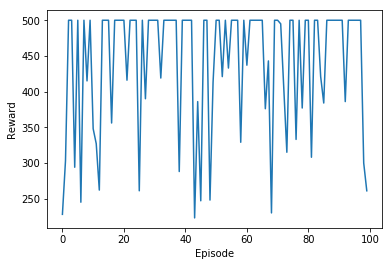

Complete
Mean:  442.23
Std:  87.91523178493007


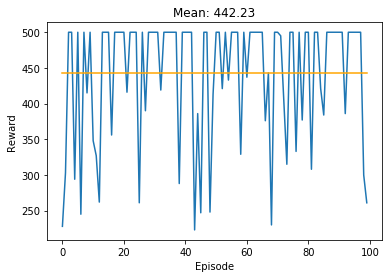

In [6]:
load_agent(env,policy_net,device,save_replay=False,max_steps=MAX_STEPS,epsilon=EPSILON)

The plot again shows the episode performances (blue) and the average performance (orange). Additionally the standard deviaton is reported. 

The presented loading method can also be used for classifiers and converted networks.

In the next experiment, we will train a classifier on the replay dataset.